# FAANG Stocks
FAANG stocks consist of Meta (formerly known as Facebook), Apple, Amazon, Netflix, and Alphabet (formerly known as Google). Collectively, these 5 companies make up about 19% of the common stock index known as the SP500 as of April 2022. To that effect, various price data has been collected from Yahoo Finance for these 5 FAANG stocks as well as the SP500 since Jan 1, 2000. If the stock IPO'd after Jan 1, 2000, the data starts at that point (for example, NFLX IPO'd on May 23, 2002, so there is only data for NFLX from that date). 

This project seeks to: 
* evaluate the growth of these stocks, 
* calculate the growth of these stocks relative to the SP500, 
* correlate FAANG stocks with each other and the SP500, 
* inspect verious technical indicators (mainly Simple Moving Averages) and predictive modeling techniques to attempt to predict strategies that lead to growth using these stocks.



## Load Dataset
We must first load the data collected from Yahoo Finance (https://finance.yahoo.com/quote/FB/history?p=FB) for the 5 stocks and SP500.

The data has a range of columns. The first column contains a Symbol (e.g. SP500, FB, AAPL, AMZN, NFLX, GOOG); a date; the day's open price, intraday high price, intraday low price, close price, adjusted close price (see below), and daily trading volume.

Adjusted close price includes additional corporate actions that occur after market close. Examples include (https://www.investopedia.com/terms/a/adjusted_closing_price.asp): 
* The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions.
* The closing price is the raw price, which is just the cash value of the last transacted price before the market closes.
* The adjusted closing price factors in corporate actions, such as stock splits, dividends, and rights offerings.
* The adjusted closing price can obscure the impact of key nominal prices and stock splits on prices in the short term.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
sb.set(rc={'figure.figsize':(20,16)})

In [2]:
stocks=pd.read_csv('faang_spy.txt',delimiter='\t')
stocks.columns=['Symbol','Date','Open','High','Low','Close','AdjClose','Volume']
print(stocks.head())
print()
print(stocks.info())

  Symbol        Date      Open      High       Low     Close  AdjClose  \
0  SP500  2022-04-14  4,449.12  4,460.46  4,390.77  4,392.59  4,392.59   
1  SP500  2022-04-13  4,394.30  4,453.92  4,392.70  4,446.59  4,446.59   
2  SP500  2022-04-12  4,437.59  4,471.00  4,381.34  4,397.45  4,397.45   
3  SP500  2022-04-11  4,462.64  4,464.35  4,408.38  4,412.53  4,412.53   
4  SP500  2022-04-08  4,494.15  4,520.41  4,474.60  4,488.28  4,488.28   

          Volume  
0  3,634,740,000  
1  3,273,140,000  
2  3,451,990,000  
3  3,452,540,000  
4  3,453,040,000  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28774 entries, 0 to 28773
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Symbol    28774 non-null  object
 1   Date      28774 non-null  object
 2   Open      28774 non-null  object
 3   High      28774 non-null  object
 4   Low       28774 non-null  object
 5   Close     28774 non-null  object
 6   AdjClose  28774 non-nul

A couple things we want to do to make the data more usable. Currently, all the column are stored as strings. We need to convert Date field to be a Date type. Then, we need to change Open, High, Low, Close, AdjClose to be floats. Finally, Volume should be an integer.

Finally, after modifying the date column, we can easily search it and Test by looking for data from April 14.

In [3]:
stocks['Date']=pd.to_datetime(stocks['Date'])
stocks=stocks.replace(',','',regex=True)
for i in ['Open','High','Low','Close','AdjClose']:
    stocks[i]=stocks[i].astype(float)
stocks['Volume']=stocks['Volume'].astype(int)

stocks[stocks['Date']=='2022-04-14']

,Symbol,Date,Open,High,Low,Close,AdjClose,Volume
0,SP500,2022-04-14,4449.120000,4460.460000,4390.770000,4392.590000,4392.590000,3634740000
10053,GOOG,2022-04-14,2612.989990,2614.205078,2542.229980,2545.060059,2545.060059,1171400
15063,NFLX,2022-04-14,350.950012,352.000000,339.859985,341.130005,341.130005,4338100
20671,AAPL,2022-04-14,170.619995,171.270004,165.039993,165.289993,165.289993,75237500
26279,AMZN,2022-04-14,3107.800049,3117.939941,3029.439941,3034.129883,3034.129883,2575200
28773,FB,2022-04-14,214.889999,214.990005,210.000000,210.179993,210.179993,18332700


How many stocks had IPOs since 2000? How many records exist for each stock?

In [4]:
stocks.groupby('Symbol')['Date'].agg(['count','min','max']).reset_index()

,Symbol,count,min,max
0,AAPL,5608,2000-01-03,2022-04-14
1,AMZN,5608,2000-01-03,2022-04-14
2,FB,2494,2012-05-18,2022-04-14
3,GOOG,4446,2004-08-19,2022-04-14
4,NFLX,5010,2002-05-23,2022-04-14
5,SP500,5608,2000-01-03,2022-04-14


We can observe that there have been 3 stocks that have IPO'd since 2000 including NFLX, GOOG, and most recently FB.

## Analysis of Growth of Stocks
First, I'm going to create a function plotstock() that will create line plots like the one seen below. I'm going to call this function multiple times, so having 1 function to modify rather than 3 separate code blocks makes sense.

In [5]:
def plotstock(stocksdf,yval="Price",ylab='Cumulative Growth Factor',title="Cumulative Growth of FAANG & SP500"):
    plt.figure(figsize=(25,20))
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    fig,ax=plt.subplots(2)
    symbols=stocksdf['Symbol'].unique()
    for i in [0,1]:
        legend=[]
        for sym in symbols[~pd.isnull(symbols)]:
            s=stocksdf[stocksdf['Symbol']==sym]
            ax[i].plot(s['Date'],s[yval])
            legend.append(sym)
        ax[i].axhline(1,color='black',linestyle='-')
        ax[i].legend(legend,loc="upper left",prop={'size': 20})
        if i==1:
            ax[i].set(yscale='log')
            ax[i].set_title("%s (Log Scale)"%title,fontsize=20,fontweight='bold')
        else:
            ax[i].set_title("%s (Linear Scale)"%title,fontsize=20,fontweight='bold')
        ax[i].set_xlabel('Date',fontsize=18)
        ax[i].set_ylabel(ylab,fontsize=18)
    plt.show()

If we plot the stocks by date and price, there are large run-ups in AMZN and GOOG, especially since 2016. The first graph show a linear scale while the second graph is a logarithmic scale.

<Figure size 1800x1440 with 0 Axes>

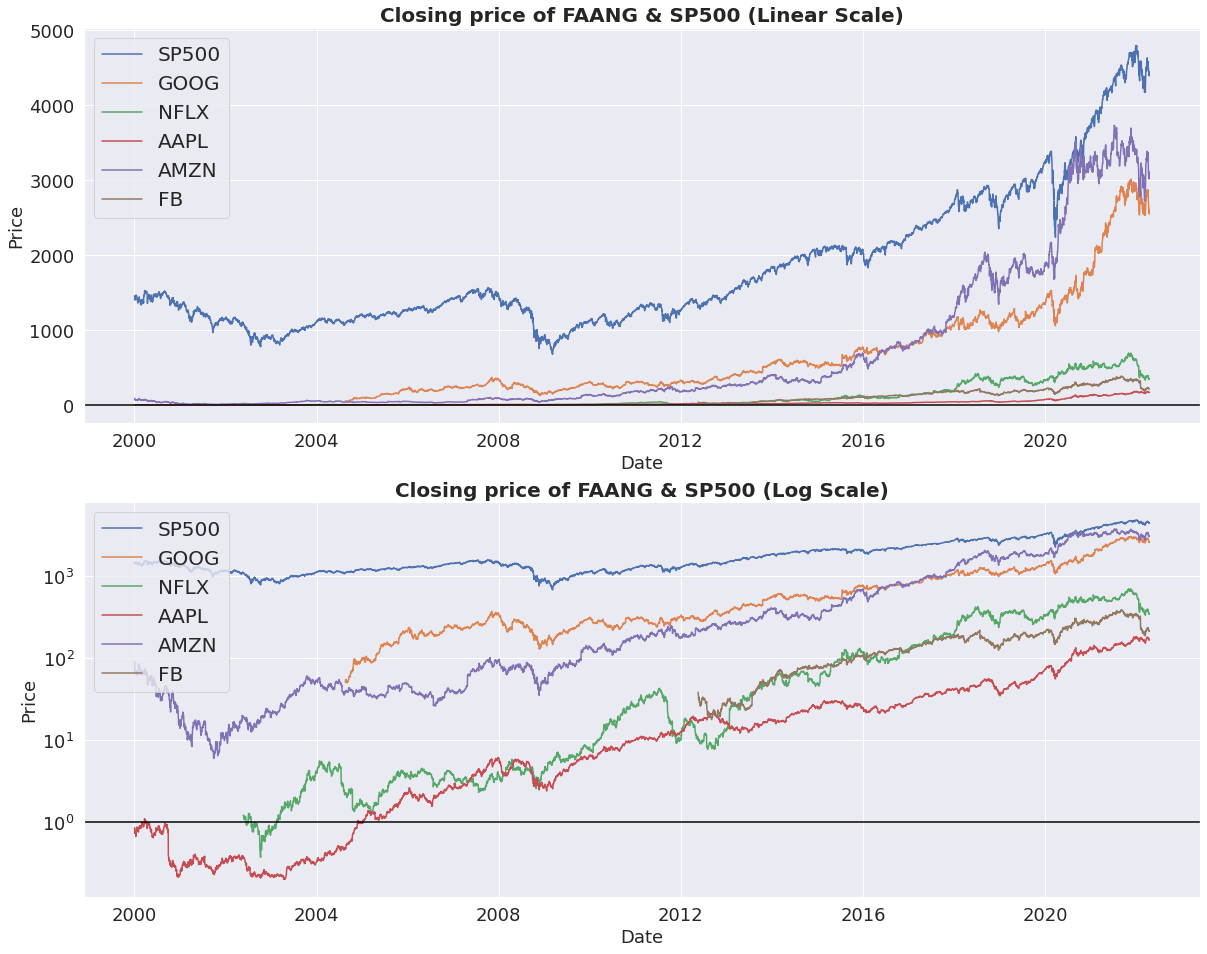

In [6]:
plotstock(stocks,yval="AdjClose",ylab='Price',title='Closing price of FAANG & SP500')

Now we need to add a few columns to the data. We need to calculate a growth for the day. That is defined as: 

$$
\begin{array}{rcl}
  growth & = & 1+\dfrac{AdjClose}{AdjClose_{yesterday}}
\end{array}
$$

Numpy has a built in pct_change() function that calculates this quickly. We'll utilize this below.

Additionally, we'll add a cumulative growth (cumgrowth) to keep track of the cumulative growth of the investment. To get a cumulative growth from daily growth, you need to take the product of all daily growths. This will be helpful later

In [7]:
first=True
for sym in stocks['Symbol'].unique():
    s=stocks[stocks['Symbol']==sym].sort_values(['Date'])
    s['growth']=s['AdjClose'].pct_change().fillna(0)+1
    s['cumgrowth']=s['growth'].cumprod()
    if first:
        stocks_growth=s
        first=False
    else:
        stocks_growth=pd.concat([stocks_growth,s])

# stocks_growth
print('AAPL start')
print(stocks_growth[stocks_growth['Symbol']=='AAPL'].head(1))
print()
print()
print('AAPL end')
print(stocks_growth[stocks_growth['Symbol']=='AAPL'].tail(1))

AAPL start
      Symbol       Date      Open      High       Low     Close  AdjClose  \
15064   AAPL 2000-01-03  0.936384  1.004464  0.907924  0.999442  0.855796   

          Volume  growth  cumgrowth  
15064  535796800     1.0        1.0  


AAPL end
      Symbol       Date        Open        High         Low       Close  \
20671   AAPL 2022-04-14  170.619995  171.270004  165.039993  165.289993   

         AdjClose    Volume    growth   cumgrowth  
20671  165.289993  75237500  0.970012  193.141815  


Using the growths, we can now calculate cumulative growths over the entire period. Apple for example closed at \$0.855796 on Jan 3, 2000. And it closed at \$165.289993 on Apr 4, 2022 for an outstanding Return on Investment (ROI) of 19,214.18% during the 22 year period!

$$
\begin{array}{rcl}
  return & = & 100*(\dfrac{165.289993}{.855796}-1)\% &=&19214.18\%
\end{array}
$$

In [8]:
sg2=stocks_growth.groupby('Symbol')['growth'].agg(['prod']).reset_index()
sg2.columns=['Symbol','ROI']
sg2['ROI']=sg2['ROI'].apply(lambda x: '-' if pd.isna(x) else '%0.2f'%((x-1)*100)+'%')
sg2

,Symbol,ROI
0,AAPL,19214.18%
1,AMZN,3294.83%
2,FB,449.78%
3,GOOG,4991.89%
4,NFLX,28412.35%
5,SP500,201.85%


We can also produce cumulative growths annually. Note the results are Annual ROIs)

In [9]:
stocks_growth['Year']=pd.DatetimeIndex(stocks_growth['Date']).year
sg=stocks_growth.groupby(['Symbol','Year'])['growth'].agg(['prod']).reset_index()
sg['growth']=(sg['prod']-1)*100
sg2=pd.pivot_table(sg,values='growth',index='Year',columns='Symbol').reset_index()

for i in ['AAPL','AMZN','FB','GOOG','NFLX','SP500']:
    sg2[i]=sg2[i].apply(lambda x: '-' if pd.isna(x) else '%0.2f'%x+'%')
sg2

Symbol,Year,AAPL,AMZN,FB,GOOG,NFLX,SP500
0,2000,-73.42%,-82.59%,-,-,-,-9.27%
1,2001,47.23%,-30.47%,-,-,-,-13.04%
2,2002,-34.57%,74.58%,-,-,-34.27%,-23.37%
3,2003,49.13%,178.56%,-,-,396.73%,26.38%
4,2004,201.36%,-15.83%,-,92.14%,-54.91%,8.99%
5,2005,123.26%,6.46%,-,115.19%,119.46%,3.00%
6,2006,18.01%,-16.31%,-,11.00%,-4.43%,13.62%
7,2007,133.47%,134.77%,-,50.17%,2.94%,3.53%
8,2008,-56.91%,-44.65%,-,-55.51%,12.28%,-38.49%
9,2009,146.90%,162.32%,-,101.52%,84.31%,23.45%


Let's plot the cumulative growth of the stocks using both a linear and logarithmic scale. \$1 invested in NFLX in 2002 would result in almost \$285 today and almost \$600 a little while ago.

<Figure size 1800x1440 with 0 Axes>

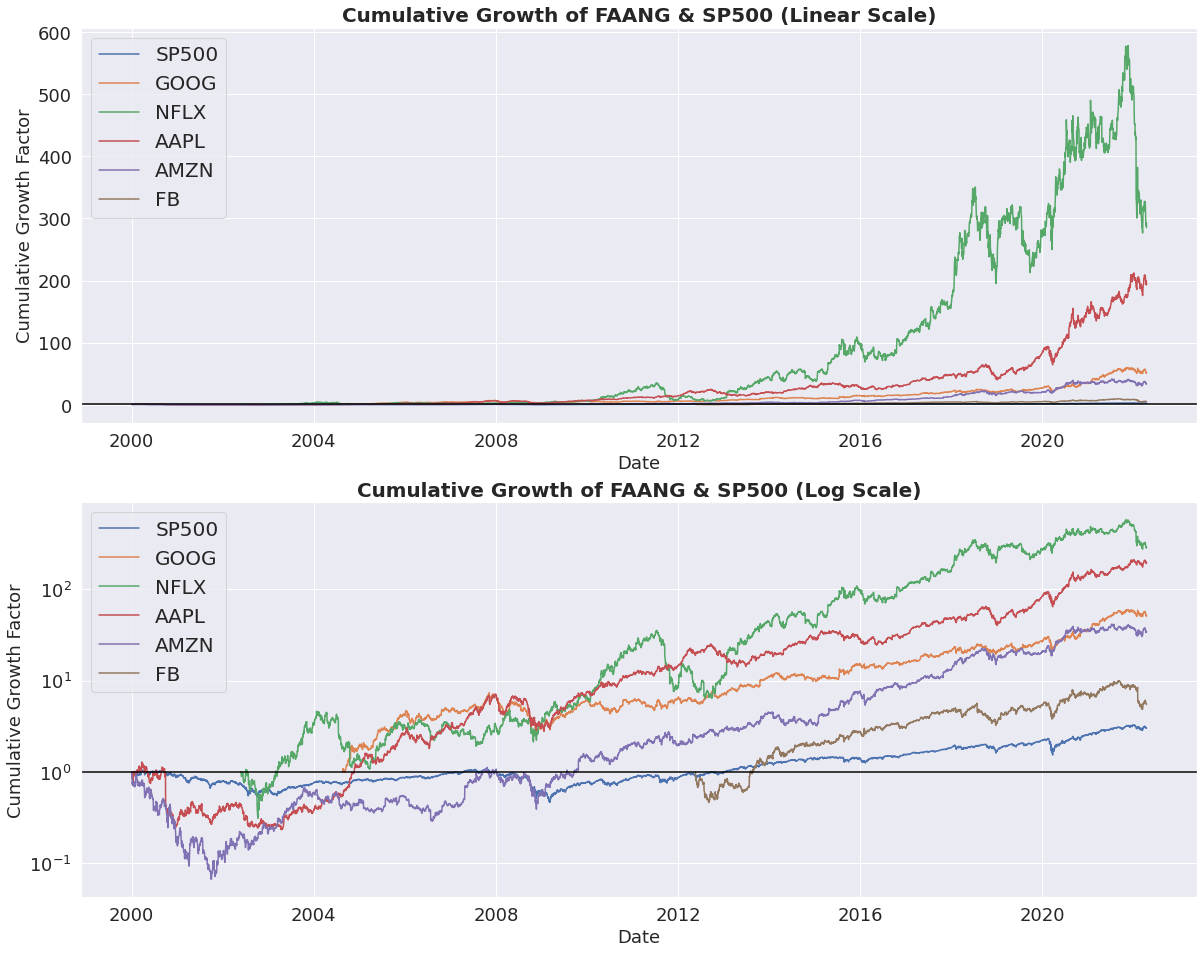

In [10]:
plotstock(stocks_growth,yval="cumgrowth",ylab='Cumulative Growth Factor',title='Cumulative Growth of FAANG & SP500')

## Correlate growths of FAANG and SP500
Lets do a quick correlations matrix of the growth rates over all the different stocks. Notice that AAPL and GOOG have high correlation coefficients with the SP500 (.67 and .7 respectively). In the plot below, the more green the number, the higher the correlation coefficient

Text(0.5, 1.0, 'Correlation Matrix of FAANG and SP500 Growths')

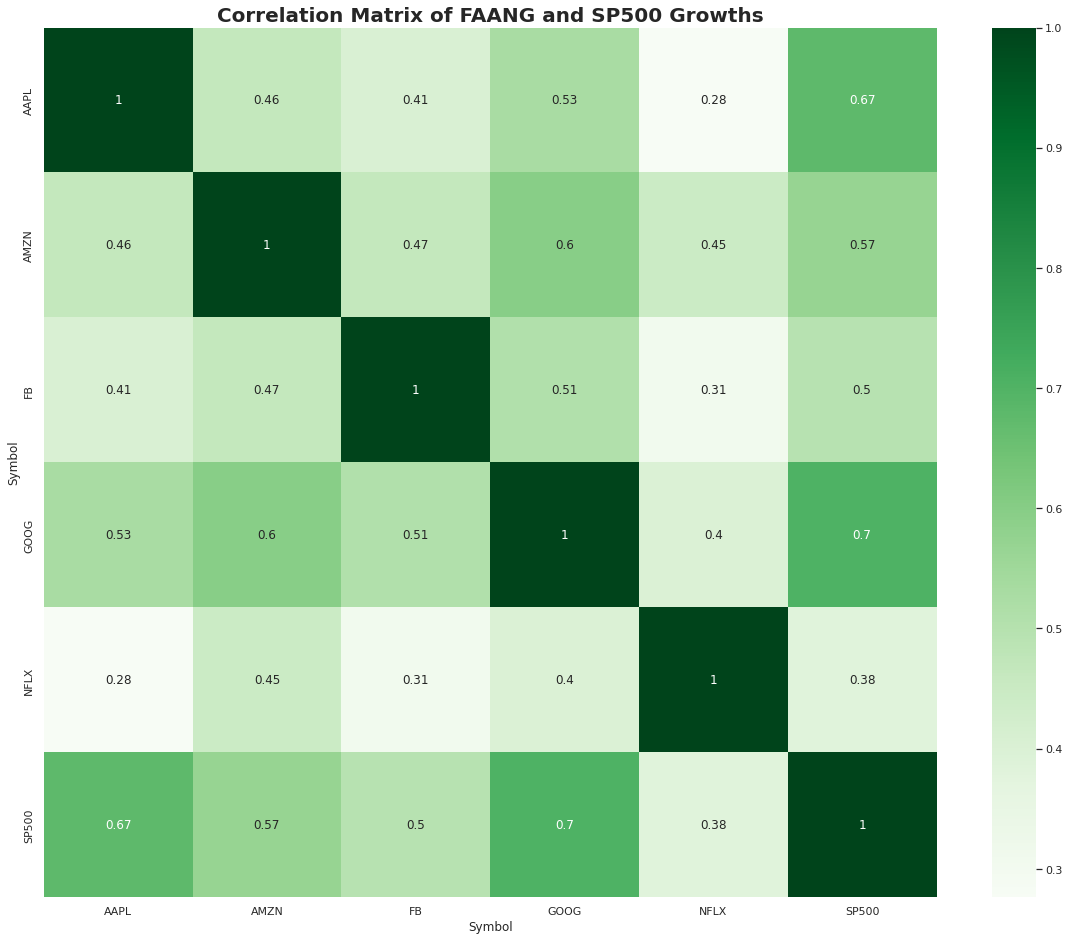

In [11]:
sg2=pd.pivot_table(stocks_growth,values='growth',index='Date',columns='Symbol').dropna().reset_index()
sb.set(rc={'figure.figsize':(20,16)})
sb.heatmap(sg2.corr(),cmap="Greens",annot=True)
plt.title("Correlation Matrix of FAANG and SP500 Growths",fontsize=20,fontweight='bold')

## Simple Moving Averages (SMA)
In technical analysis, one of the most rudimentry indicators is when you compare multiple simple moving averages. The most common comparsion compares a 50 day and a 200 day moving averages. When the 50 day is greater than the 200 day, this is said to be the "Golden Cross". When the 50 day is less than the 200 day, this is said to be the "Death Cross" https://www.investopedia.com/terms/g/goldencross.asp#:~:text=A%20golden%20cross%20is%20a%20technical%20chart%20pattern%20indicating%20the,indicating%20a%20bearish%20price%20movement. 

Let's suppose, you wanted to buy and hold a stock when the Golden Cross condition exists and not hold the stock when the Death Cross exists. How would that portfolio of stocks perform?

The first block below calculates the SMA50 and SMA200 and simulates the strategy. The second code block calculates cumulative growth from the strategy.

In [12]:
first=True
for sym in stocks_growth['Symbol'].unique():
    s=stocks_growth[stocks_growth['Symbol']==sym].loc[:,['Symbol','Date','AdjClose','growth']].copy(deep=True)
    s['SMA50']=s['AdjClose'].rolling(window=50).mean()
    s['SMA200']=s['AdjClose'].rolling(window=200).mean()
    s['buyhold']=(s['SMA50']>=s['SMA200']).astype(int)
    if first:
        stocks_sma=s
        first=False
    else:
        stocks_sma=pd.concat([stocks_sma,s])

In [13]:
strat=stocks_sma[stocks_sma['buyhold']==1]
first=True
datesdf=pd.DataFrame(stocks_sma['Date'].unique())
datesdf.columns=['Date']
for sym in strat['Symbol'].unique():
    s=strat[strat['Symbol']==sym].copy(deep=True)
    s['cumgrowth']=s['growth'].cumprod()
    s2=pd.merge(datesdf,s,on=["Date"],how="left")
    s2=s2.fillna(method='ffill')
    if first:
        stratresults=s2
        first=False
    else:
        stratresults=pd.concat([stratresults,s2])
stratresults.groupby(['Symbol']).last().reset_index()

,Symbol,Date,AdjClose,growth,SMA50,SMA200,buyhold,cumgrowth
0,AAPL,2022-04-14,165.289993,0.970012,167.784200,158.097204,1.0,147.737411
1,AMZN,2022-04-14,2890.879883,1.013327,3388.855215,3388.293704,1.0,52.839295
2,FB,2022-04-14,329.820007,0.997761,330.747601,330.268950,1.0,3.981103
3,GOOG,2022-04-14,2686.159912,0.996709,2755.628418,2749.780059,1.0,7.017658
4,NFLX,2022-04-14,429.480011,0.939514,559.465201,559.150698,1.0,141.165306
5,SP500,2022-04-14,4204.310000,0.987038,4476.070200,4467.134800,1.0,3.504397


We see that the cumulative growth for AAPL and NFLX following that strategy is astronomical. Let's next plot the results using a linear yaxis first and then using a logarithmic scale second so that we can see the plots more clearly.

<Figure size 1800x1440 with 0 Axes>

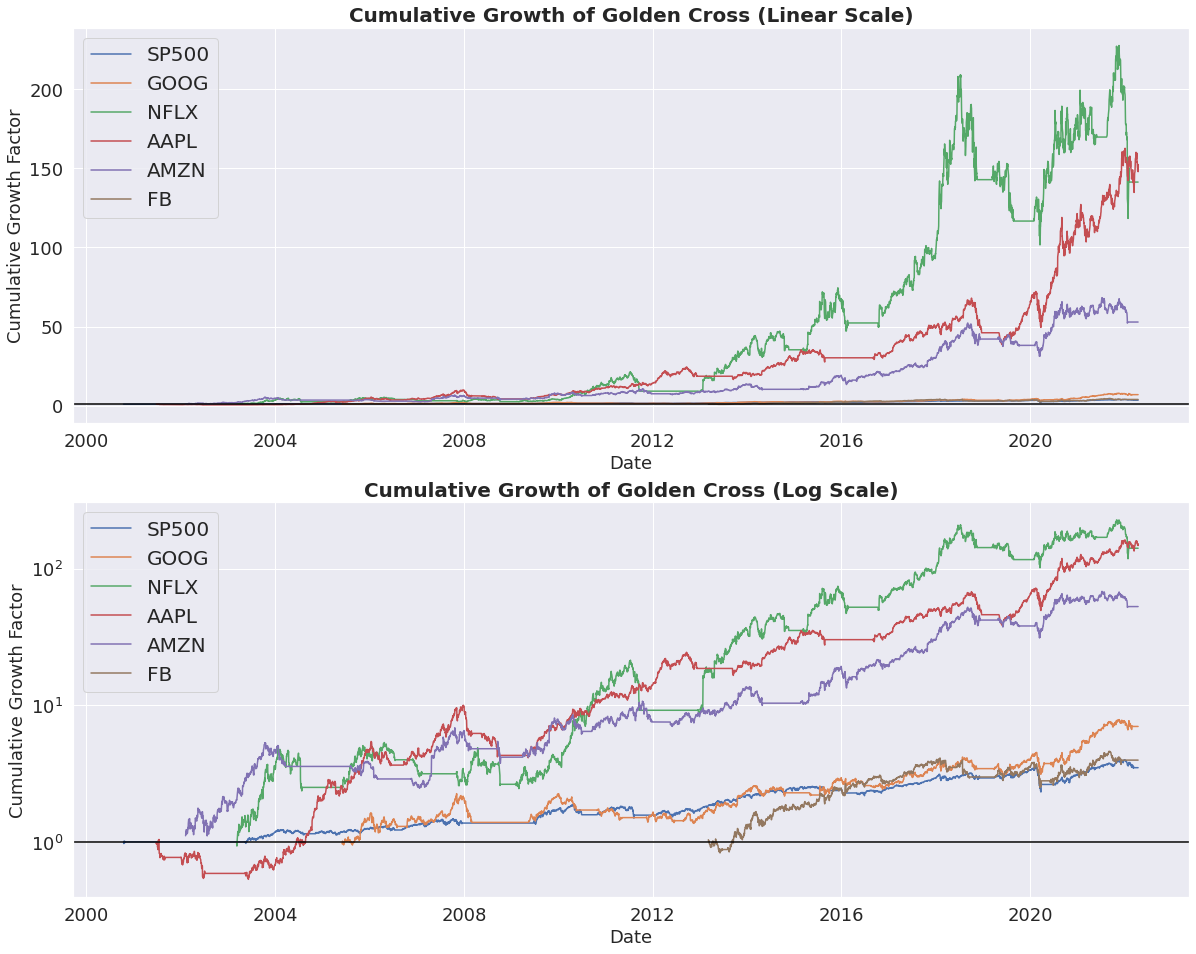

In [14]:
plotstock(stratresults,yval="cumgrowth",ylab='Cumulative Growth Factor',title='Cumulative Growth of Golden Cross')

## SMA part 2 - Predictive Model
Now that we've seen tremendous growth from a simple Golden Cross (albeit, not as great as if you just invested in the FAANG stocks), lets see if there's anyway to use a logistic regression and a collection of lookback windows to predict growth for these stocks.

First, lets create the Simple Moving Averages with lookbacks of 1, 2, 3, 5, 10, 20, 30, 50, 100, 150, 200, 250 days. Then lets create 66 different buy and hold strategies, similar to the 50/200 that we used above, from the different lookbacks. For example, the different strategies would be bh_1_2 which would correspond to when the SMA1 >=SMA2.

Finally, while we're here, we're going to create a binary growth response variable. Basically, a boolean that denotes if the growth is greater than or equal to 1.

In [15]:
first=True
for sym in stocks_growth['Symbol'].unique():
    s=stocks_growth[stocks_growth['Symbol']==sym].loc[:,['Symbol','Date','AdjClose','growth']].copy(deep=True)
    smlookbacks=[1,2,3,5,10,20,30,50,100,150,200,250]
    for i in smlookbacks:
        s['SMA%s'%i]=s['AdjClose'].rolling(window=i).mean()
    
    for i in range(len(smlookbacks)):
        vali=smlookbacks[i]
        for j in range(i+1,len(smlookbacks)):
            valj=smlookbacks[j]
            s['bh_%s_%s'%(vali,valj)]=(s['SMA%s'%vali]>=s['SMA%s'%valj]).astype(int)

    s['growthresponse']=(s['growth']>=1).astype(int)
    if first:
        stocks_sma=s
        first=False
    else:
        stocks_sma=pd.concat([stocks_sma,s])

print(stocks_sma[stocks_sma['Date']=='2022-04-11'])

      Symbol       Date     AdjClose    growth         SMA1         SMA2  \
3      SP500 2022-04-11  4412.530000  0.983123  4412.530000  4450.405000   
10050   GOOG 2022-04-11  2595.929932  0.968555  2595.929932  2638.069947   
15060   NFLX 2022-04-11   348.000000  0.977858   348.000000   351.940002   
20668   AAPL 2022-04-11   165.750000  0.974484   165.750000   167.919998   
26276   AMZN 2022-04-11  3022.439941  0.978386  3022.439941  3055.824951   
28770     FB 2022-04-11   216.460007  0.973598   216.460007   219.395004   

              SMA3         SMA5        SMA10        SMA20  ...  bh_50_150  \
3      4467.006667  4481.458000  4530.025000  4493.156000  ...          0   
10050  2668.479981  2714.043994  2776.794995  2763.193506  ...          0   
15060   355.343333   362.906000   372.738000   372.036500  ...          0   
20668   169.326665   170.973999   173.896001   170.352001  ...          1   
26276  3089.113281  3144.712012  3233.395996  3222.860010  ...          0   
28770

### SMA Logistic Regression
Let's build a dataset for the logistic regression. It'll consist of all the different BH indicators as well as the growthresponse variable that we created previously.

We're going to split our dataset into 2 sets, a trainset and a testset with roughly a 80/20 split. To accomplish this, everything prior to Jan 1, 2018 will be in our trainset while everything after and including Jan 1, 2018 will be in our testset.

In [16]:
#build dataset for logistic regression
logcols=['growthresponse']
cols=stocks_sma.columns
for i in cols:
    if i[0:2]=='bh':
        logcols.append(i)

dt='2018-01-01'
train_sma=stocks_sma[stocks_sma['Date']<dt][logcols].reset_index(drop=True)

logcols.append('Symbol')
logcols.append('growth')
test_sma=stocks_sma[stocks_sma['Date']>=dt][logcols].reset_index(drop=True)

The code below is verifying that our trainset is about 77.5% of our total data.

In [17]:
print(train_sma.shape)
print(test_sma.shape)
train_sma.shape[0]/(train_sma.shape[0]+test_sma.shape[0])

(22294, 67)
(6480, 69)


0.7747966914575659

Let's do a couple checks on the features. We want to check and remove any features that are very highly correlated with the growthresponse (our dependent variable). Here, we see that bh_1_2 has nearly a perfect correlation to growth. bh_1_3 also has a high correlation. We'll remove those 2 from our logistic regression to ensure there's no forward-looking bias.

Text(0.5, 1.0, 'Correlation Matrix of SMA Features')

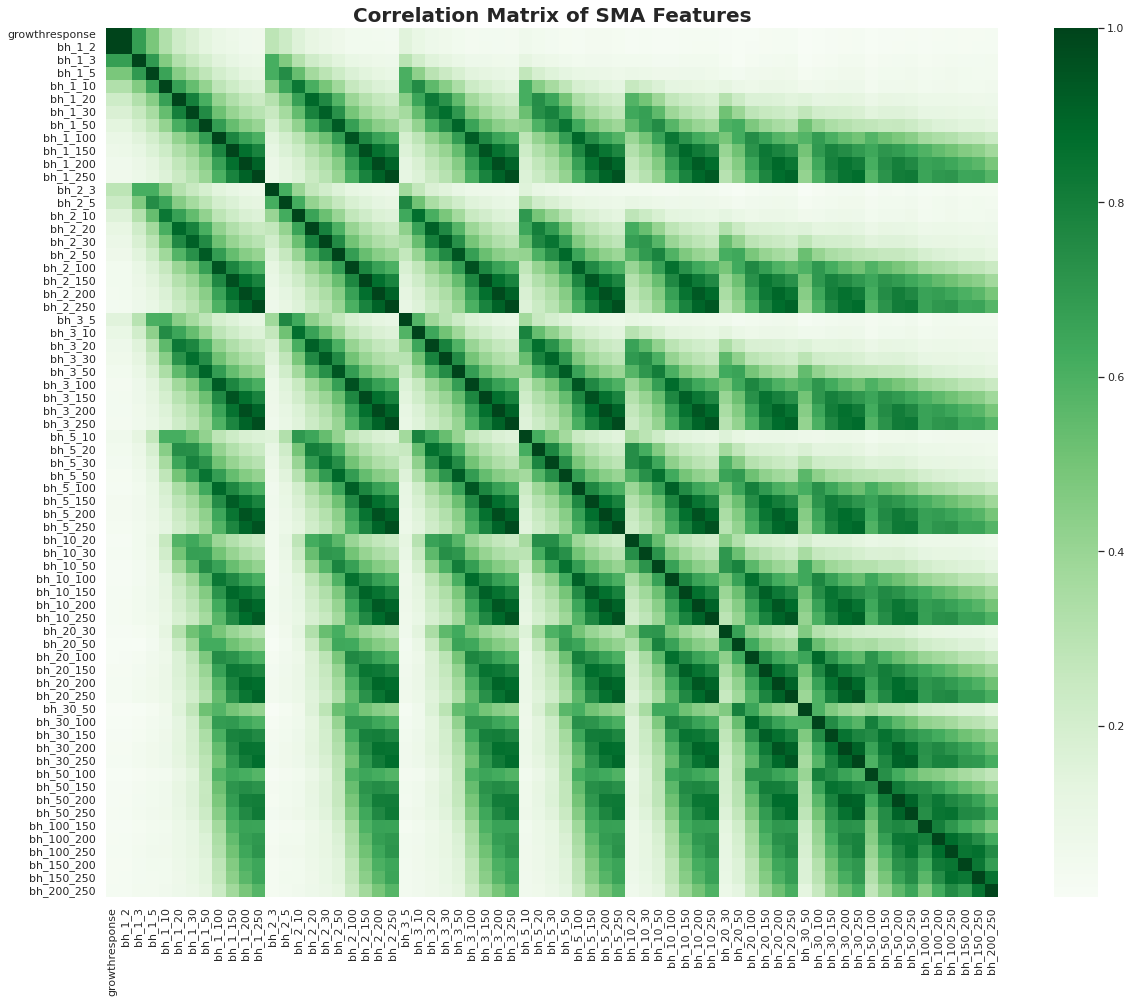

In [18]:
sb.set(rc={'figure.figsize':(20,16)})
sb.heatmap(train_sma.corr(),cmap="Greens")
plt.title("Correlation Matrix of SMA Features",fontsize=20,fontweight='bold')

Below, is where we remove the 2 independent variables identified as having a high correlation. Additionally, logcols2 will be solely all the features that we're going to include in our logistic regression

In [19]:
logcols=train_sma.columns
logcols2=[]
for i in logcols:
    if i!='bh_1_2' and i!='bh_1_3' and i!='growthresponse':
        logcols2.append(i)

The next couple code blocks are donig a few more administrative things. First, we want to see the class distribution of the response variable. We're looking for ones that are relatively balanced i.e. 50/50. We don't want to see highly unbalanced classes i.e. 99/1. We see here, that the response variable, as well as the features have good class distributions and we're excited to move forward

Text(0.5, 1.0, 'growthresponse Value Counts')

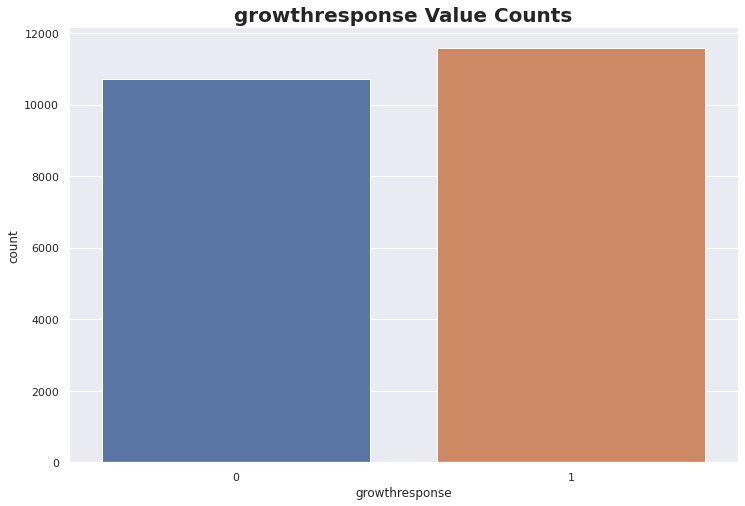

In [20]:
sb.set(rc={'figure.figsize':(12,8)})
sb.countplot(x=train_sma['growthresponse'])
plt.title("growthresponse Value Counts",fontsize=20,fontweight='bold')

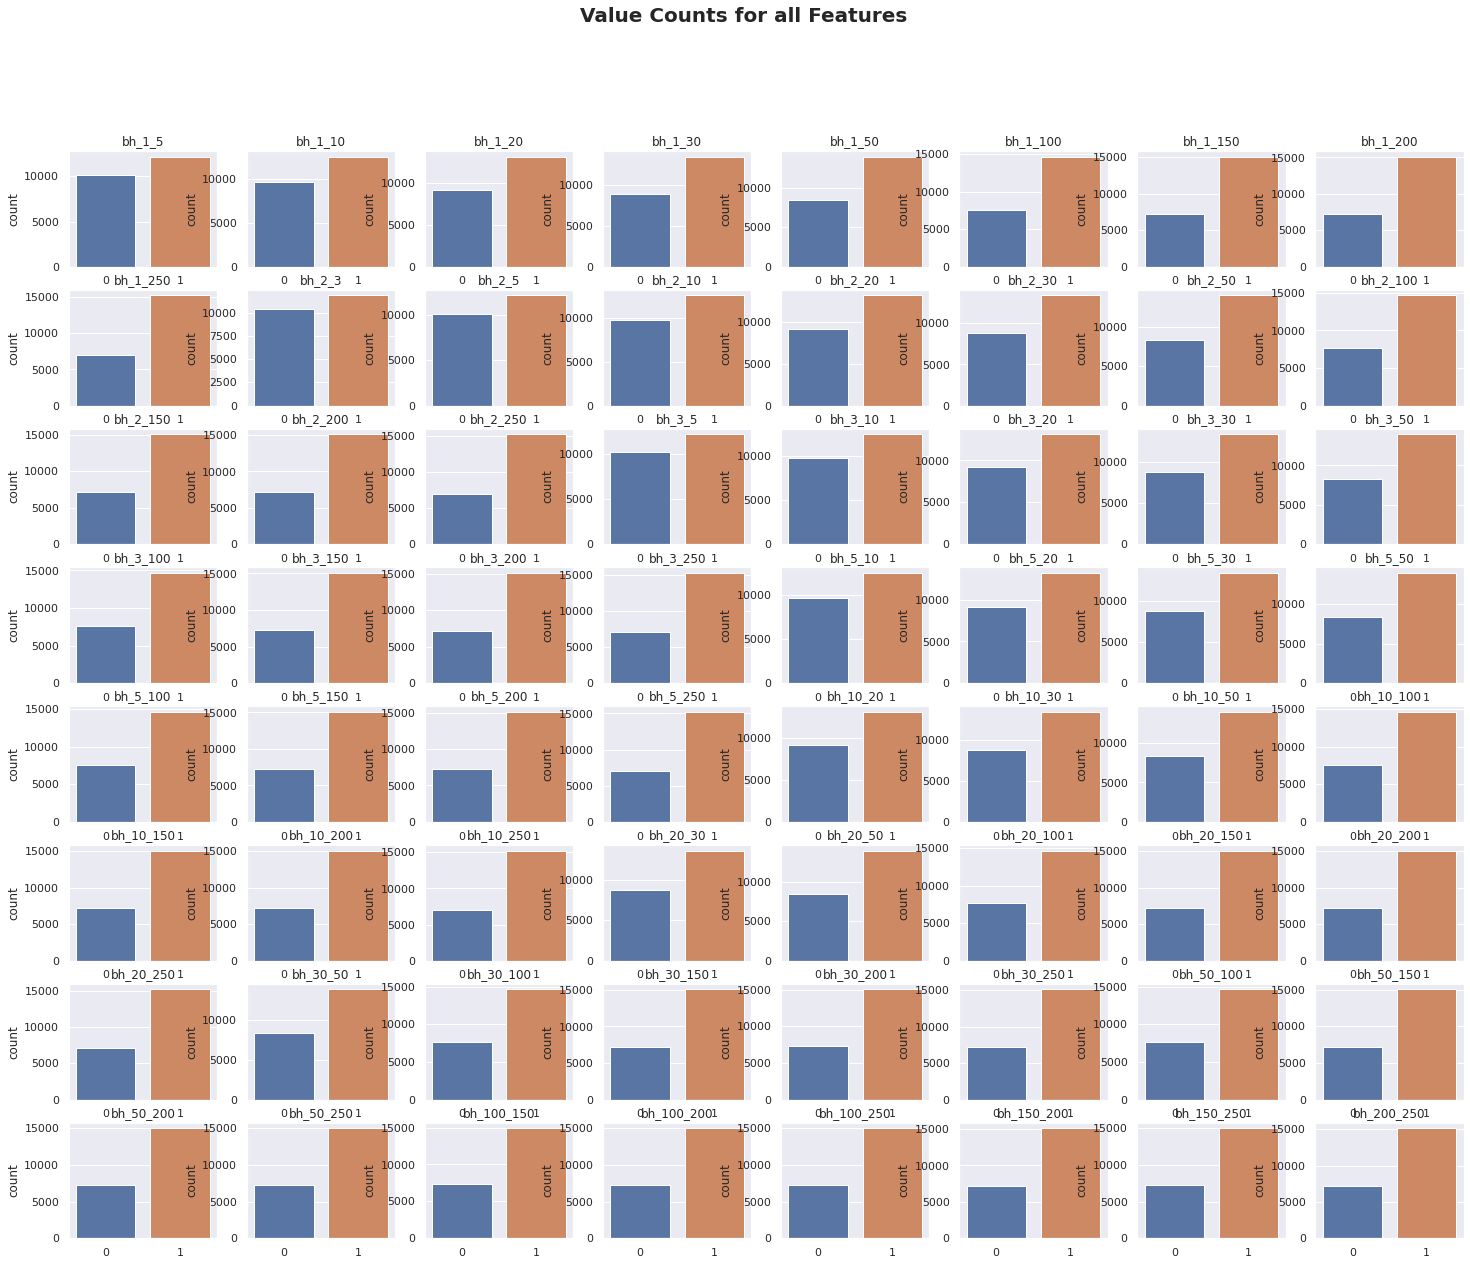

In [21]:
sb.set(rc={'figure.figsize':(25,20)})
fig,ax=plt.subplots(8,8)
fig.suptitle('Value Counts for all Features',fontsize=20,fontweight='bold')
for i in range(len(logcols2)):
    ival=logcols2[i]
    f=i//8
    a=i%8
    sb.countplot(x=train_sma[ival],ax=ax[f,a]).set(title=ival,xlabel=None)
plt.show()

### Logistic Regression FINALLY!
Finally, we are ready to build a Logistic regression trying to predict whether the day will be up/down based on the different features previously identified. We're going to use the trainset to build the model.

Additionally, we're going to plot the Logistic Regression's features and their importance. The ones with a lookback of 1 incorporated appear to be used heavily by the regression.

In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500)
logreg.fit(train_sma[logcols2], train_sma['growthresponse'])

LogisticRegression(max_iter=500)

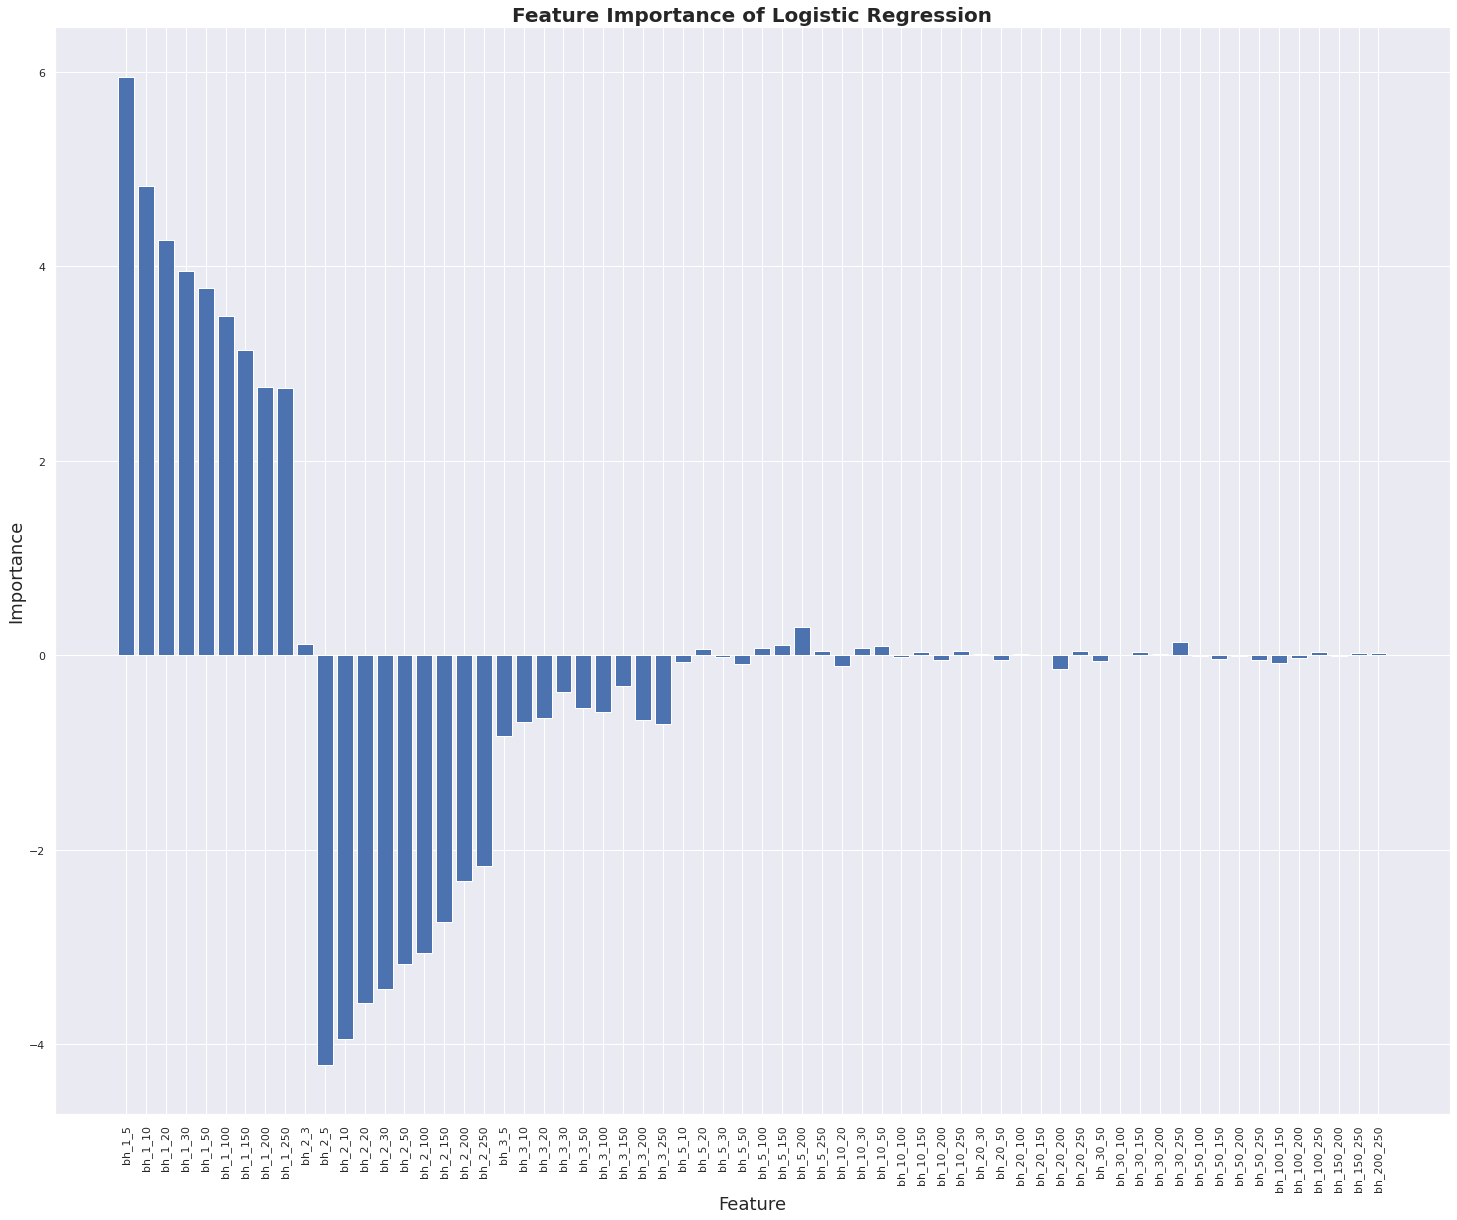

In [23]:
importance=logreg.coef_[0]
# for i,v in zip(logcols2,importance):
#     print('Feature: %s, Score: %.5f' % (i,v))
# plot feature importance
plt.bar(logcols2, importance)
plt.xticks(rotation=90)
plt.ylabel('Importance',fontsize=18)
plt.xlabel('Feature',fontsize=18)
plt.title('Feature Importance of Logistic Regression',fontsize=20,fontweight='bold')
plt.show()

And we can now use that logistic regression to predict how the model would predict on the testset. We'll store in ypred for evaluation of the predicted values against the actual values.

In [24]:
ypred=logreg.predict(test_sma[logcols2])

### Model Evaluation
So how did the model do. Looking quickly, we can see that the model predicts about 79% of the days up/down correctly from Jan 2018 - Apr 2022.

In [25]:
logreg.score(test_sma[logcols2],test_sma['growthresponse'])

0.7862654320987654

Looking at the Confusion matrix and the classification report, we'll be able to determine how many values were predicted accurately by the model. Additionally, we'll be able to see the Type I and Type II errors from the Confusion Matrix. 

Finally, looking at the Classification Report, we'll be able to determine the precision (how accurate the model's True predictions were) and recall (how accurately the model predicted True events). Additionally, F1 scores (takes into account both precision and recall) as well as Accuracy are also detailed.

In [26]:
from sklearn.metrics import confusion_matrix,classification_report
confusion_matrix(test_sma['growthresponse'],ypred)

array([[2179,  829],
       [ 556, 2916]])

In [27]:
print(classification_report(test_sma['growthresponse'],ypred))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      3008
           1       0.78      0.84      0.81      3472

    accuracy                           0.79      6480
   macro avg       0.79      0.78      0.78      6480
weighted avg       0.79      0.79      0.79      6480



How effective is the model? A common evaluation method is to use a Receiver Operating Characteristic (ROC) curve. A model that follows the diagonal is said to have minimal to no predictive power. But the more area under curve (AUC) that a model has, the better it is. The AUC ranges from 0 to 1, and ideally, you want a model with close to a .9 AUC. As we see here, this model's AUC is .78. There's some predictive power, but there's likely more than can be harnessed.

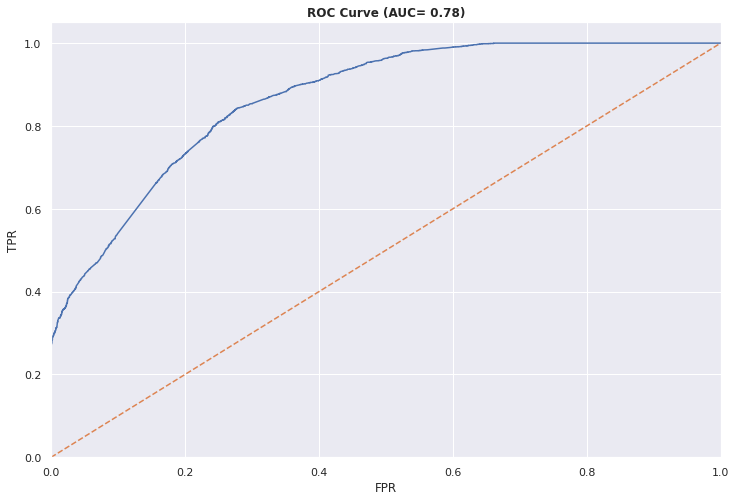

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve
AUC = roc_auc_score(test_sma['growthresponse'],ypred)
fpr, tpr, thresholds = roc_curve(test_sma['growthresponse'], logreg.predict_proba(test_sma[logcols2])[:,1])
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (AUC= %0.2f)'%AUC,fontweight='bold')
plt.show()

Finally, let's add in the growths and see how the Logistic Regression model would perform. We can compare the original (no model labeled cumgrowth_orig), the Golden Cross (SMA50>=SMA200 labeled cumgrowth_goldencross), and finally the Logistic Regression model (labeled cumgrowth_model). Since the Logistic Regression only has data since Jan 1, 2018, we need to ensure that the other 2 are only using data since Jan 1, 2018 as well.

In [29]:
test_sma['pred']=ypred
modelpred_growth=test_sma[test_sma['pred']==1]

out_modelpred=modelpred_growth[["Symbol",'growth']].groupby('Symbol')['growth'].agg(['prod']).reset_index()
out_modelpred.columns=['Symbol','cumgrowth_model']

out_orig=stocks_growth[stocks_growth['Date']>=dt].groupby('Symbol')['growth'].agg(['prod']).reset_index()
out_orig.columns=['Symbol','cumgrowth_orig']

out_goldencross=stratresults[stratresults['Date']>=dt].groupby('Symbol')['growth'].agg(['prod']).reset_index()
out_goldencross.columns=['Symbol','cumgrowth_goldencross']

pd.merge(out_orig,out_goldencross,on=['Symbol']).merge(out_modelpred,on=['Symbol'])

,Symbol,cumgrowth_orig,cumgrowth_goldencross,cumgrowth_model
0,AAPL,4.090102,0.294701,1071.087999
1,AMZN,2.594449,9.601425,948.772990
2,FB,1.191091,76.725623,1172.822655
3,GOOG,2.432206,2.320436,437.797981
4,NFLX,1.777089,0.005747,3683.202577
5,SP500,1.642943,0.070826,45.652867


Looks like the Logistic Regression model is killing it! For example, a \$1 investment in AAPL on Jan 1, 2018, would result in \$4.09 if just put in a Buy and Hold, \$0.30 if using the Golden Cross method, and \$1071 using the Logistic Regression.
## Conclusion
This concludes this analysis of FAANG stocks and the SP500. It's important to note that FAANG stocks are a group of the best performing stocks over the past decade, especially the last half of the decade. There is likely high survivorship bias incorporated into these stocks.

For future research, it would be interesting to determine if this analysis and logistic regression model can be expanded to more stocks than just the FAANG stocks. Additionally, given how well the Logistic Regression performed, there could be some forward looking features in the Logistic Regression. Verifying that this is not the case should also be performed.